# HW5 Machine translation with Encoder-Decoder model

## Due April 24th, 23:59

In this homework, you are first shown an example of encoder-decoder machine translation model for a dummy problem. Make sure you understand how it works. Then you will need to build a similar model for a real machine translation data set. The data set provided in this homework is an italiano-english dataset (perché italiano 
è mia lingua preferita), but feel free to download your preferred language pari here (http://www.manythings.org/anki/).


You are given the following files:
- `Machine-Translation.ipynb`: This notebook file
- `ita.txt`: Training dataset (see http://www.manythings.org/anki/ to understand the structure)
- `utils/`: folder containing all utility code for the series of homeworks


### Deliverables (zip them all)

- pdf or html version of your final notebook
- Show some translation examples in your notebook
- writeup.pdf: Add a short essay discussing the biggest challenges you encounter during this assignment and what you have learnt.

(**You are encouraged to add the writeup doc into your notebook
using markdown/html langauge, just like how this notes is prepared**)

# Set up

In [132]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
# add utils folder to path
p = os.path.dirname(os.getcwd())
if p not in sys.path:
    sys.path = [p] + sys.path

from utils.general import show_keras_model

from keras.models import Model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dummy Translation Problem
We are not doing anything real here, rather, we create a dummy problem to demonstrate how easy or hard to use a S2S model for machine translation.

The dummy prblem I choose here is to translate datestr like "Aug-30-1989" to another format "1989/08/30". Sounds easy, isn't it? But think about it, you feel this simple because you have so much prior knowledge. You know the English meaning of "Aug", you know the different ways of representing dates, MM-DD-YYYY vs YYYY/MM/DD. But our model starts from absolute ignorance. Imagine you show this problem to a 2-year-old child, how much time does it make for him to figure out the rule? 

## Generate Training Data

In [133]:
import numpy as np

choice = np.random.choice
def source_generation(batch=100):
    months = choice(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], batch)
    days = choice(range(1, 28), batch)
    years = choice(range(1990, 2050), batch)
    
    return [ f"{m}-{d}-{y}" for m, d, y in zip(months, days, years)]

def translate(src):
    if type(src) == str: src = [src]
    mmap = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': "06", 'Jul': "07", 
            'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}
    result = []
    for d in src:
        m, d, y = d.split('-')
        result.append(f"{y}/{mmap[m]}/{str(d).rjust(2, '0')}")
        
    return result

In [134]:
# Let's generate some data
train_X_raw = source_generation(10000)
train_Y_raw = translate(train_X_raw)

# Verify the translation
print(train_X_raw[:5])
print(train_Y_raw[:5])

['Jan-19-2030', 'May-3-2000', 'Apr-26-2017', 'May-5-2044', 'Apr-26-2011']
['2030/01/19', '2000/05/03', '2017/04/26', '2044/05/05', '2011/04/26']


## Other dummy tasks

You are encouraged to generate your own dummy tasks, for example, what about a simple calculator, can you train your model to understand "186+95" equal to "281"?

# Encoder-Decoder Model

In [135]:
encoder_input_len = 11
decoder_input_len = 10
latent_dim = 256

## Raw data transformer

As of today, I guess you should be quite familar with what we are doing here.

In [ ]:
from keras.preprocessing.sequence import pad_sequences

char_vocab = list('ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz-/0123456789$^')

reverse_vocab = {k:v for v, k in enumerate(char_vocab)}
def char_to_num(X_raw, is_encoder=True):
    """
    Translate the raw input to the numerical encoding. We take different treatments for the
    encoder inputs and decoder inputs. This is because we need a starter character "^" for the 
    decoder inputs.
    """
    result = [[reverse_vocab[c] for c in sent] for sent in X_raw]
    
    if(is_encoder):
        assert all([len(row) <= encoder_input_len for row in X_raw])
        return pad_sequences(sequences=result, maxlen=encoder_input_len, 
                             padding='post', truncating='post', 
                             value=reverse_vocab['$'])
    else:
        assert all([len(row) == decoder_input_len for row in X_raw])
        return pad_sequences(sequences=result, maxlen=decoder_input_len+1, 
                             padding='pre', truncating='post', 
                             value=reverse_vocab['^'])

    return pad_sequences(result)

def num_to_char(X):
    return [''.join([char_vocab[c] for c in row]) for row in X]

## Training model

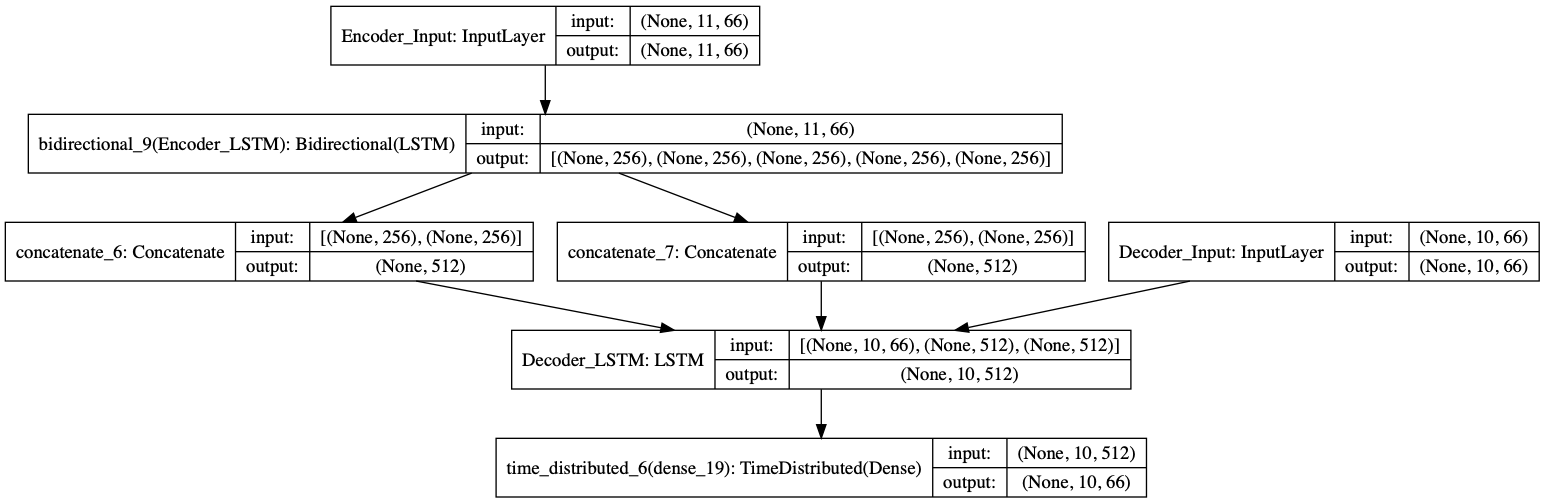

In [174]:
# from keras.models import Model
from keras.layers import (Input, LSTM, Dense, Bidirectional, Embedding, 
                          TimeDistributed, Concatenate)

"""
Define an input Layer. We use one-hot encoding instead of embedding layer here. Since
we are using character based model, embedding may not be necessary, and may not be very 
helpful neither. Do you know why?
"""
encoder_inputs = Input(shape=(encoder_input_len, len(char_vocab)), name="Encoder_Input")
# For encoder, we can see the entire sentence at once, so we can use Bidirectional LSTM
encoder_lstm = Bidirectional(LSTM(latent_dim, return_state=True, name="Encoder_LSTM"))
# Bidrectional LSTM has 4 states instead of 2, we concatenate them to be comparable
# with the decoder LSTM
_, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_inputs)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

# Set up the decoder, using `encoder_states` as initial state
encoder_states = [state_h, state_c]
decoder_inputs = Input(shape=(decoder_input_len, len(char_vocab)), name="Decoder_Input")
decoder_lstm = LSTM(latent_dim*2, return_sequences=True, name="Decoder_LSTM")
decoder_lstm_outputs = decoder_lstm(decoder_inputs,
                                    initial_state=encoder_states)
decoder_dense = Dense(len(char_vocab), activation='softmax')
decoder_outputs = TimeDistributed(decoder_dense)(decoder_lstm_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

show_keras_model(model)

## Train training model

In [175]:
# Run training
from keras.utils import to_categorical
"""
Don't be suprized that this model actually needs quite quite a lot of epochs to train, so please be patient.
After the model is trained, you can use the history.history object to plot the metrics improvment process.

While you are waiting for the model to train, feel free to read the next cell.
"""
batch_size = 1000
epochs = 75

# Here it's just some data transformation to translate the raw data to matrix inputs
encoder_input_data = to_categorical(char_to_num(train_X_raw, True), num_classes=len(char_vocab))
train_Y = to_categorical(char_to_num(train_Y_raw, False), num_classes=len(char_vocab))
# for decoder, the target lags input by 1 time step
decoder_input_data = train_Y[:, :-1, :]
decoder_target_data = train_Y[:, 1:, :]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 15s 2ms/step - loss: 3.6577 - accuracy: 0.2229 - val_loss: 2.4895 - val_accuracy: 0.3084
Epoch 2/50
8000/8000 [==============================] - 15s 2ms/step - loss: 2.1568 - accuracy: 0.2814 - val_loss: 1.9610 - val_accuracy: 0.2975
Epoch 3/50
8000/8000 [==============================] - 17s 2ms/step - loss: 1.9018 - accuracy: 0.3382 - val_loss: 1.8418 - val_accuracy: 0.3844
Epoch 4/50
8000/8000 [==============================] - 17s 2ms/step - loss: 1.7935 - accuracy: 0.3928 - val_loss: 1.7394 - val_accuracy: 0.3896
Epoch 5/50
8000/8000 [==============================] - 17s 2ms/step - loss: 1.7023 - accuracy: 0.3983 - val_loss: 1.6563 - val_accuracy: 0.3948
Epoch 6/50
8000/8000 [==============================] - 17s 2ms/step - loss: 1.6128 - accuracy: 0.4373 - val_loss: 1.5493 - val_accuracy: 0.4825
Epoch 7/50
8000/8000 [==============================] - 17s 2ms/step - loss: 1.501

## Inference model

Similar to HW04, we need a different model structure for the inference model. The inference model should copy exactly the same weights from the training model, but it predicts only 1 time step at a time.

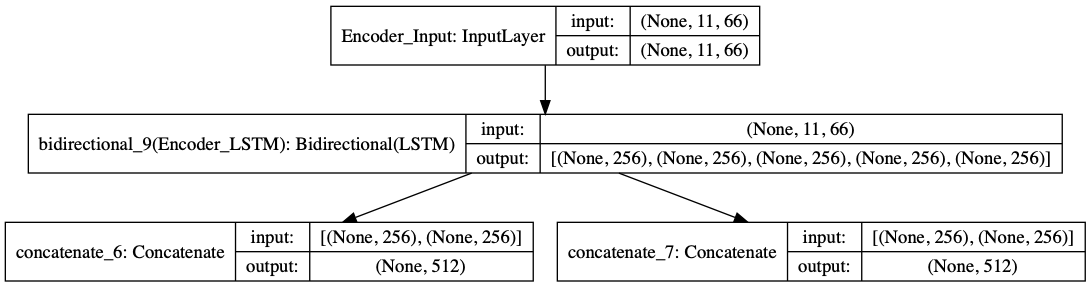

In [176]:
# Trucate the encoder part of the training model as encoder model
encoder_model = Model(encoder_inputs, encoder_states)
show_keras_model(encoder_model)

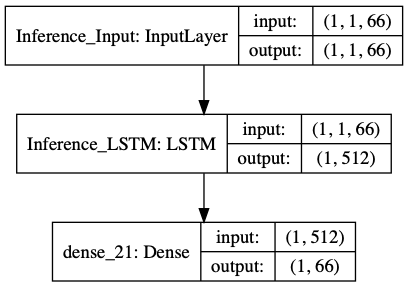

In [178]:
# Build the inference model
inference_inputs = Input(batch_shape=(1,1, len(char_vocab)), name="Inference_Input")
inference_lstm = LSTM(latent_dim*2, stateful=True,
                      name="Inference_LSTM")
inference_lstm_outputs = inference_lstm(inference_inputs)

inference_dense = Dense(len(char_vocab), activation='softmax')
inference_outputs = inference_dense(inference_lstm_outputs)

# Assign the weights of decoder to inference model
inference_lstm.set_weights(decoder_lstm.get_weights())
inference_dense.set_weights(decoder_dense.get_weights())

inference_model = Model(inference_inputs, inference_outputs)
show_keras_model(inference_model)

In [181]:
def inference(encoder_input_data):
    """
    A utility function to generate the model prediction
    """
    states_h, states_c = encoder_model.predict(encoder_input_data)
    results = []
    
    for h, c in zip(states_h, states_c):
        sent, seed = [], reverse_vocab['A']
        inference_lstm.states[0].assign(h[None, :])
        inference_lstm.states[1].assign(c[None, :])
        for i in range(decoder_input_len):
            seed = to_categorical(np.array([seed]), num_classes=len(char_vocab))[None, :, :]
            seed = inference_model.predict(seed)[0].argmax()
            sent.append(seed)
            
        results.append(sent)
        
    return num_to_char(results)

In [182]:
# Let's look at some output
print(num_to_char(encoder_input_data[:10].argmax(axis=2)))
print(inference(encoder_input_data[:10]))

['Jan-19-2030', 'May-3-2000$', 'Apr-26-2017', 'May-5-2044$', 'Apr-26-2011', 'Aug-21-1994', 'Oct-12-1998', 'Feb-7-2010$', 'Apr-15-2015', 'May-3-2019$']
['2030/01/19', '2000/05/03', '2017/04/26', '2044/05/05', '2011/04/27', '1994/08/21', '1998/10/22', '2010/02/07', '2015/04/15', '2019/05/03']


# Real Machine translation 

In [198]:
"""
Now are you ready for the real challenge? You can use the ita.txt file as training data. 
But feel free to download different language from http://www.manythings.org/anki/. If you
happen to speak French or Japanese, it's time to show off!

1. Implement a Bidrectional LSTM Encoder-Decoder model, or other viable models to translate 
   the language dataset you choose.

2. Write the function to calculate the BLEU score of your model
"""

"""
Implement me!
"""


'\nImplement me!\n'